In [2]:
pip install squarify

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.graph_objects as go

import squarify
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = "/content/drive/MyDrive/Dataset/OnlineRetail.csv"
df = pd.read_csv(file_path, sep=",", encoding="ISO-8859-1", header=0)
print(df.head(5))


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.isnull()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
541904,False,False,False,False,False,False,False,False
541905,False,False,False,False,False,False,False,False
541906,False,False,False,False,False,False,False,False
541907,False,False,False,False,False,False,False,False


In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<Axes: >

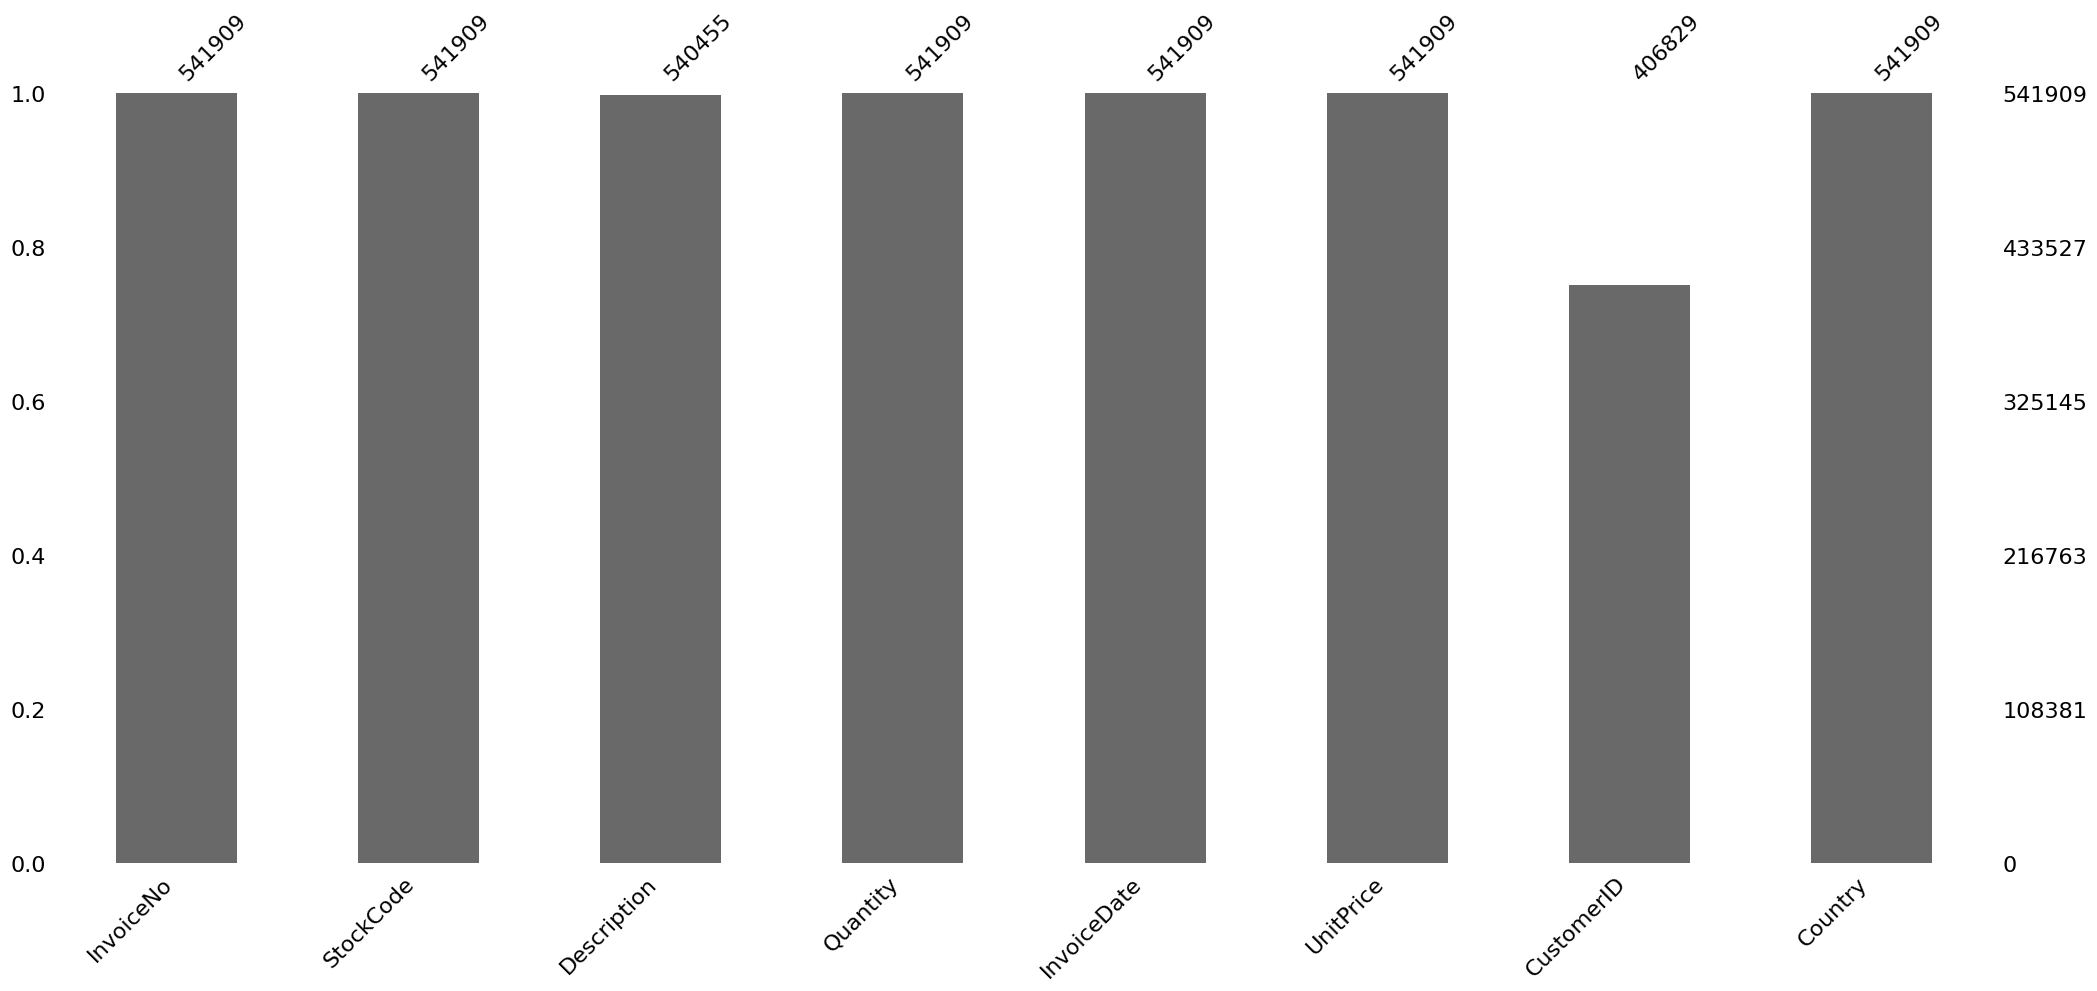

In [9]:
import missingno as msno
msno.bar(df)

In [10]:
df = df.dropna()
df.shape

(406829, 8)

<Axes: >

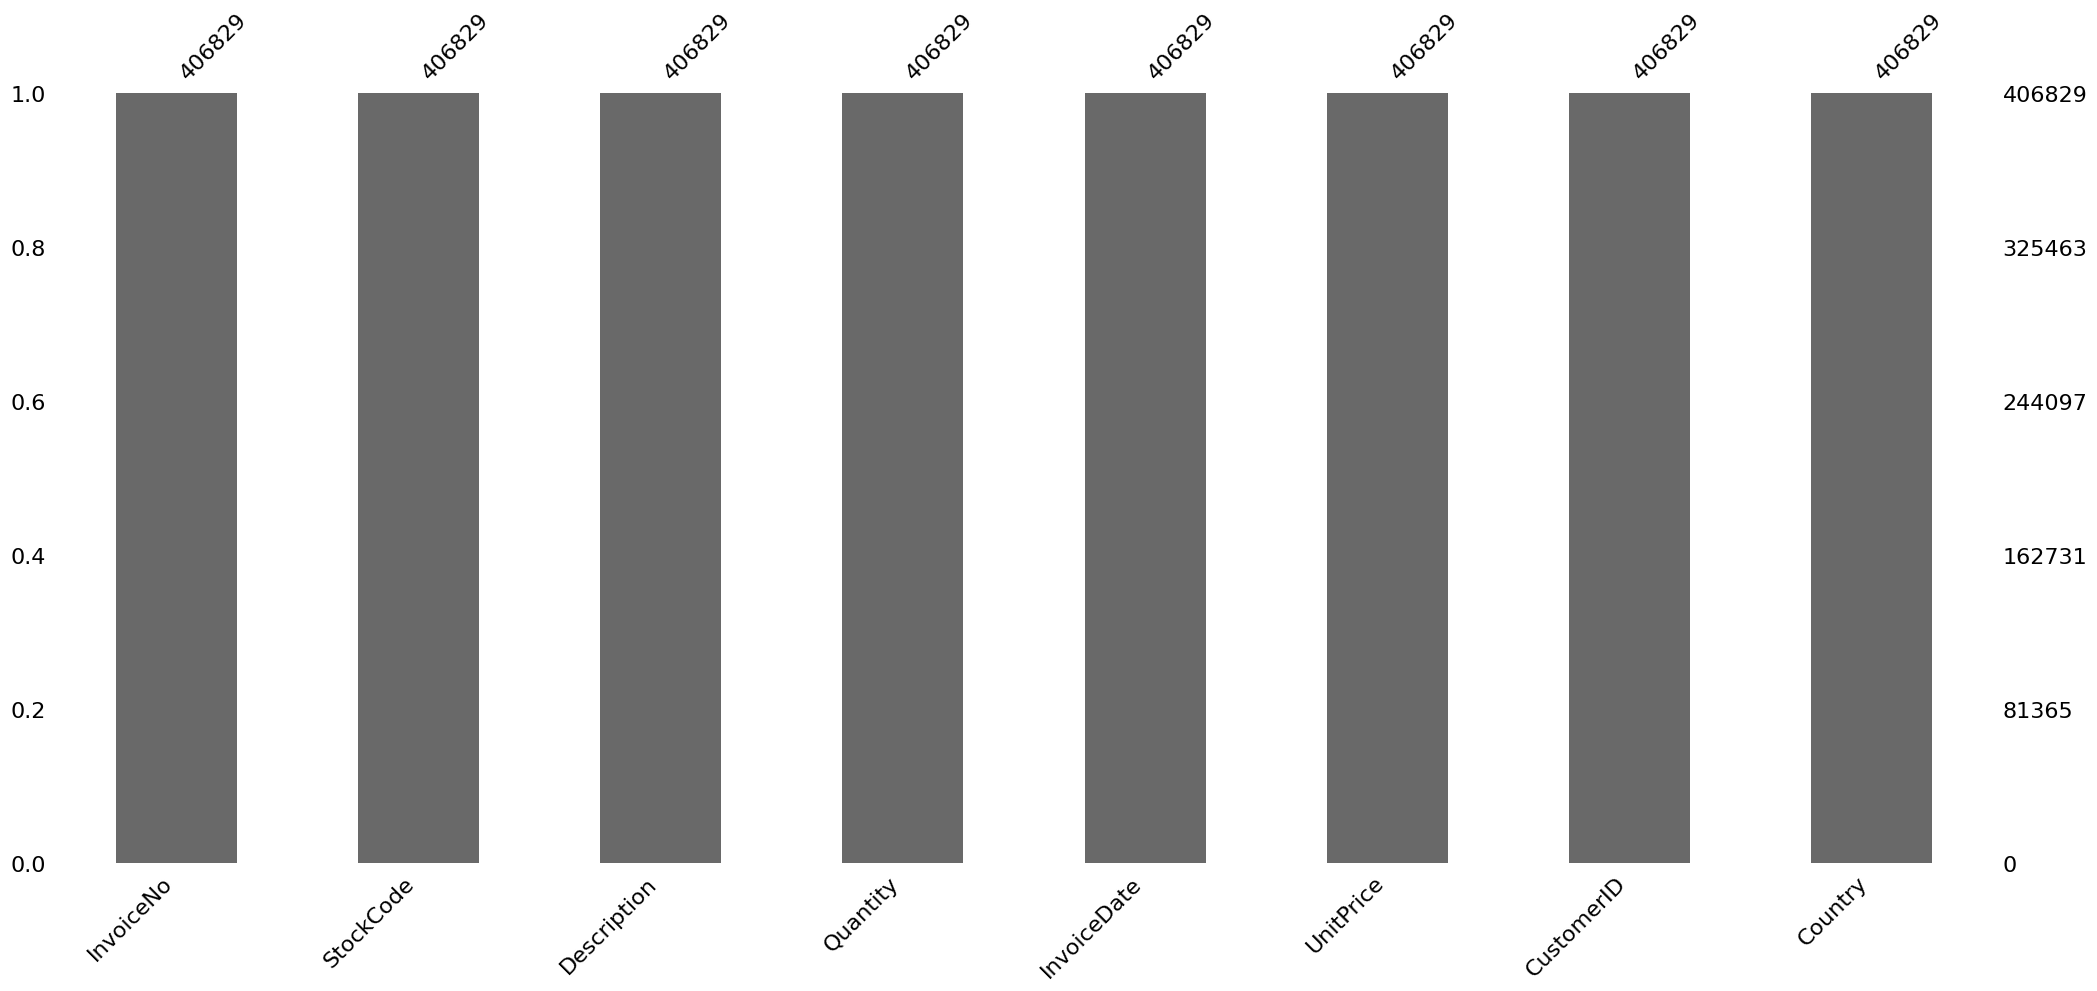

In [11]:
msno.bar(df)

In [12]:
#checking for duplicates
df.duplicated().sum()

5225

In [13]:
#removing duplicates
df.drop_duplicates(keep='first', inplace=True)
df.shape

(401604, 8)

In [14]:
retail = df.copy()

In [15]:
#calculate revenue per row and add new column
retail['Revenue'] = retail['Quantity'] * retail['UnitPrice']

In [16]:
retail['InvoiceDate'] = retail['InvoiceDate'].str.replace(' ', '')
retail.InvoiceDate = pd.to_datetime(retail['InvoiceDate'], format='%m/%d/%Y%H:%M')


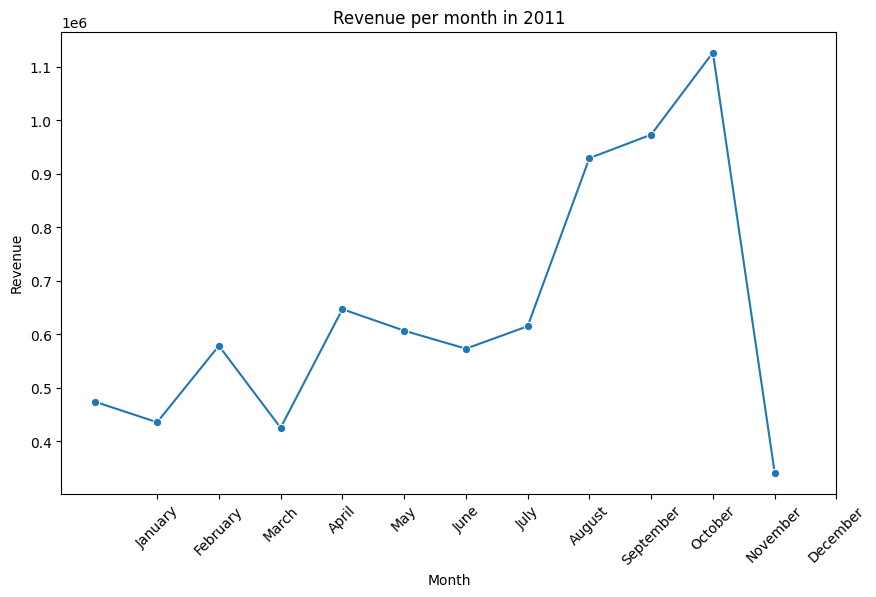

In [17]:
import calendar

retail_month = retail[retail.InvoiceDate.dt.year == 2011]
monthly_gross = retail_month.groupby(retail_month.InvoiceDate.dt.month).Revenue.sum()

# Convert month numbers to month names
monthly_gross.index = monthly_gross.index.map(lambda x: calendar.month_name[x])

plt.figure(figsize=(10, 6))

sns.lineplot(y=monthly_gross.values, x=monthly_gross.index, marker='o')

plt.xticks(range(1, 13), calendar.month_name[1:13], rotation=45)
plt.title("Revenue per month in 2011")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


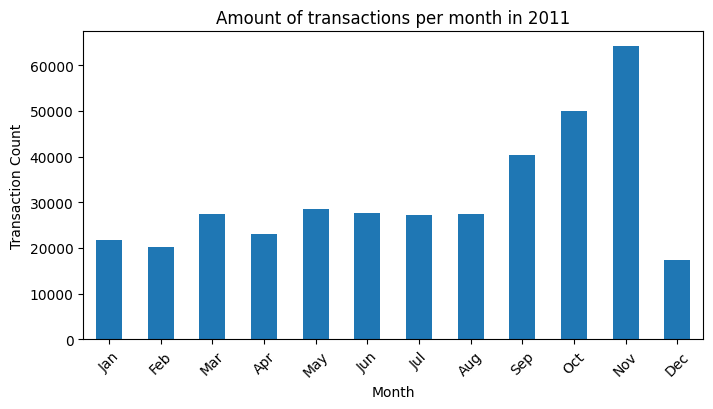

In [18]:
plt.figure(figsize=(8, 4))
retail[retail.InvoiceDate.dt.year == 2011].InvoiceDate.dt.month.value_counts(sort=False).sort_index().plot(kind='bar')
plt.title("Amount of transactions per month in 2011")
plt.xlabel("Month")
plt.ylabel("Transaction Count")
plt.xticks(range(12), calendar.month_abbr[1:13], rotation=45)
plt.show()


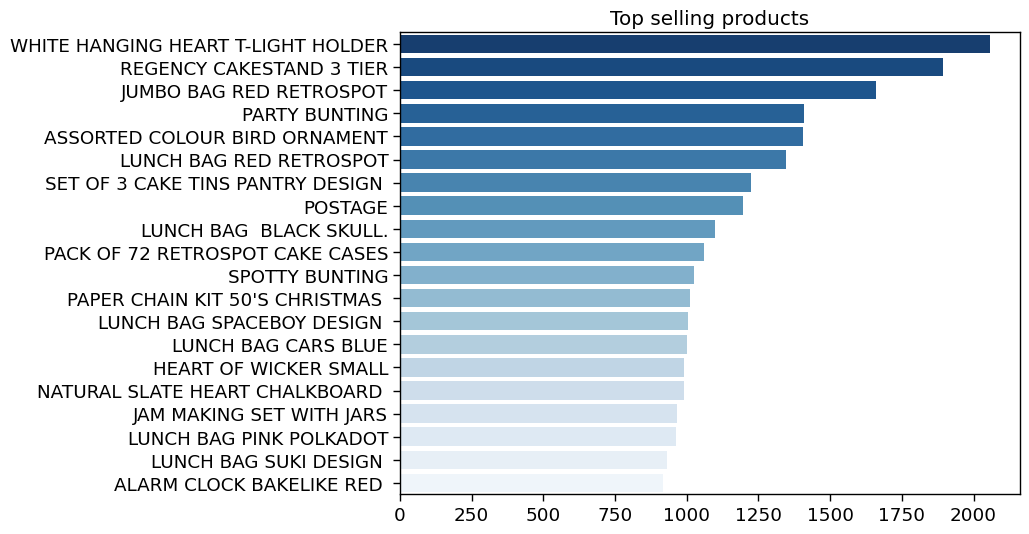

In [19]:
top_products = retail['Description'].value_counts()[:20]

plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y=top_products.index,
            x=top_products.values,
            palette='Blues_r')  # Change the palette to 'Blues_r'
plt.title("Top selling products")
plt.savefig('top_products.png')
plt.show()


# Data Preparation - RFM Model

In [20]:
# Calculate the monetary value (amount spent) for each customer
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']

# Group the data by CustomerID and calculate the sum of Amount for each customer
retail_mv = retail.groupby(['CustomerID']).agg({'Amount': 'sum'}).reset_index()

# Display the first few rows of the DataFrame
retail_mv.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [21]:
# Group the data by CustomerID and count the unique InvoiceNo values to calculate frequency
retail_f = retail.groupby('CustomerID')['InvoiceNo'].nunique()

# Reset the index of the resulting Series and convert it to a DataFrame
retail_f = retail_f.reset_index()

# Display the first few rows of the DataFrame
retail_f.head()


,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [22]:
# Convert the 'InvoiceDate' column to datetime format
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Find the maximum date in the 'InvoiceDate' column
max_date = max(retail['InvoiceDate'])

# Calculate the difference between the maximum date and each transaction date
retail['Diff'] = max_date - retail['InvoiceDate']

# Display the first few rows of the DataFrame with the added 'Diff' column
retail.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00


In [23]:
# Merge the 'retail_mv' and 'retail_f' DataFrames based on 'CustomerID'
retail_mv_f = pd.merge(retail_mv, retail_f, on='CustomerID', how='inner')

# Display the first few rows of the merged DataFrame
retail_mv_f.head()


,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,7
2,12348.0,1797.24,4
3,12349.0,1757.55,1
4,12350.0,334.40,1


In [24]:
# Calculate the minimum 'Diff' (recency) per customer
retail_r = retail.groupby('CustomerID')['Diff'].min()

# Reset the index and convert the 'Diff' column to number of days
retail_r = retail_r.reset_index()
retail_r['Diff'] = retail_r['Diff'].dt.days

# Display the resulting DataFrame
retail_r.head()


,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [25]:
# Merge the 'retail_mv_f' and 'retail_r' DataFrames based on 'CustomerID'
retail_rfm = pd.merge(retail_mv_f, retail_r, on='CustomerID', how='inner')

# Rename the columns in the merged DataFrame
retail_rfm.columns = ['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']

# Display the first few rows of the merged DataFrame
retail_rfm.head()


,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,7,1
2,12348.0,1797.24,4,74
3,12349.0,1757.55,1,18
4,12350.0,334.40,1,309


In [26]:
# Define labels for recency groups
r_labels = range(4, 0, -1)

# Assign recency groups using qcut
r_groups = pd.qcut(retail_rfm.Recency, q=4, labels=r_labels)

# Define labels for frequency groups
f_labels = range(1, 4)  # Updated: Changed from range(1, 5) to range(1, 4)

# Assign frequency groups using qcut with 'drop' for duplicates
f_groups = pd.qcut(retail_rfm.Frequency, q=4, labels=f_labels, duplicates='drop')

# Define labels for monetary value groups
m_labels = range(1, 5)

# Assign monetary value groups using qcut
m_groups = pd.qcut(retail_rfm.MonetaryValue, q=4, labels=m_labels)


In [27]:
# Assign group labels to new columns
retail_rfm['R'] = r_groups.values
retail_rfm['F'] = f_groups.values
retail_rfm['M'] = m_groups.values

# Create an RFM segment by concatenating the R, F, and M values
retail_rfm['RFM_Segment'] = retail_rfm.apply(lambda x: str(int(x['R'])) + str(int(x['F'])) + str(int(x['M'])), axis=1)

# Calculate the RFM score by summing the R, F, and M values
retail_rfm['RFM_Score'] = retail_rfm[['R', 'F', 'M']].sum(axis=1)

# Display the resulting DataFrame
retail_rfm.head()


,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score
0,12346.0,0.00,2,325,1,1,1,111,3
1,12347.0,4310.00,7,1,4,3,4,434,11
2,12348.0,1797.24,4,74,2,2,4,224,8
3,12349.0,1757.55,1,18,3,1,4,314,8
4,12350.0,334.40,1,309,1,1,2,112,4


In [28]:
# Define score labels for RFM levels
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']

# Assign score labels to RFM score groups using qcut
score_groups = pd.qcut(retail_rfm.RFM_Score, q=4, labels=score_labels)

# Create a new column 'RFM_Level' and assign the score groups
retail_rfm['RFM_Level'] = score_groups.values

# Sort the DataFrame by RFM score in descending order
retail_rfm = retail_rfm.sort_values(by='RFM_Score', ascending=False)

# Display the first 10 rows of the DataFrame
retail_rfm.head()


,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level
982,13658.0,2421.47,7,9,4,3,4,434,11,Gold
1767,14732.0,2686.34,10,7,4,3,4,434,11,Gold
3641,17293.0,1854.06,9,7,4,3,4,434,11,Gold
1319,14121.0,2740.30,6,3,4,3,4,434,11,Gold
1144,13881.0,16989.52,22,3,4,3,4,434,11,Gold


In [29]:
#This will return the Gold level RFM Value
gold_rfm = retail_rfm[retail_rfm['RFM_Level'] == 'Gold']
print(gold_rfm)


      CustomerID  MonetaryValue  Frequency  Recency  R  F  M RFM_Segment  \
982      13658.0        2421.47          7        9  4  3  4         434   
1767     14732.0        2686.34         10        7  4  3  4         434   
3641     17293.0        1854.06          9        7  4  3  4         434   
1319     14121.0        2740.30          6        3  4  3  4         434   
1144     13881.0       16989.52         22        3  4  3  4         434   
...          ...            ...        ...      ... .. .. ..         ...   
3513     17101.0        1621.73          4        9  4  2  4         424   
3516     17107.0       10362.48          7       32  3  3  4         334   
3520     17114.0         739.72         10        5  4  3  3         433   
1747     14704.0        1493.96          9       10  4  3  3         433   
3532     17131.0        2463.17          5        4  4  2  4         424   

      RFM_Score RFM_Level  
982          11      Gold  
1767         11      Gold  
364

In [30]:
#Count the number of RFM Value
retail_rfm_levels = retail_rfm.groupby('RFM_Level')['CustomerID'].count().reset_index(name='counts')
retail_rfm_levels.head()


,RFM_Level,counts
0,Green,1113
1,Bronze,1199
2,Silver,1199
3,Gold,861


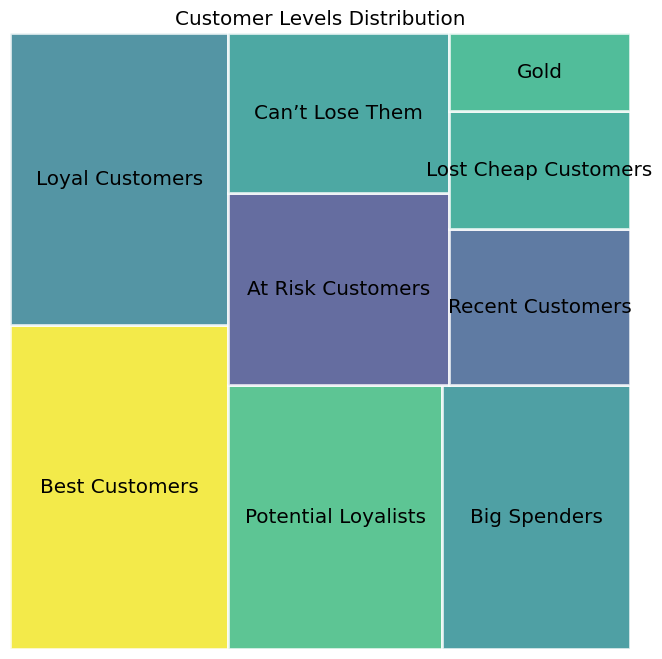

In [31]:
# Define the levels and score lists based on the data you have
levels = ['Best Customers', 'Loyal Customers', 'Potential Loyalists', 'Big Spenders', 'At Risk Customers', 'Can’t Lose Them', 'Recent Customers', 'Lost Cheap Customers', 'Gold']
score = [100, 90, 80, 70, 60, 50, 40, 30, 20]

# Exclude the 'Others' segment from visualization
filtered_levels = levels[:-1]
filtered_score = score[:-1]

# Add the 'Gold' segment back to the visualization
filtered_levels.append(levels[-1])
filtered_score.append(score[-1])

# Create the plot
plt.figure(figsize=(8, 8))
plt.title('Customer Levels Distribution')
squarify.plot(sizes=filtered_score, label=filtered_levels, alpha=0.8, edgecolor='white', linewidth=2)

# Remove axis labels
plt.axis('off')

# Display the plot
plt.show()


In [32]:
highest_rfm_score = retail_rfm['RFM_Segment'].max()
print(highest_rfm_score)


434


In [33]:
# Sort the DataFrame by RFM score in descending order
retail_rfm_sorted = retail_rfm.sort_values(by='RFM_Score', ascending=False)

# Get the best customer (first row) with the highest RFM score
best_customer = retail_rfm_sorted.iloc[0]

# Display the best customer information
print(best_customer)


CustomerID       13658.0
MonetaryValue    2421.47
Frequency              7
Recency                9
R                      4
F                      3
M                      4
RFM_Segment          434
RFM_Score             11
RFM_Level           Gold
Name: 982, dtype: object


In [34]:
loyal_customers = retail_rfm[retail_rfm['RFM_Level'] == 'Gold']
print(loyal_customers)

      CustomerID  MonetaryValue  Frequency  Recency  R  F  M RFM_Segment  \
982      13658.0        2421.47          7        9  4  3  4         434   
1767     14732.0        2686.34         10        7  4  3  4         434   
3641     17293.0        1854.06          9        7  4  3  4         434   
1319     14121.0        2740.30          6        3  4  3  4         434   
1144     13881.0       16989.52         22        3  4  3  4         434   
...          ...            ...        ...      ... .. .. ..         ...   
3513     17101.0        1621.73          4        9  4  2  4         424   
3516     17107.0       10362.48          7       32  3  3  4         334   
3520     17114.0         739.72         10        5  4  3  3         433   
1747     14704.0        1493.96          9       10  4  3  3         433   
3532     17131.0        2463.17          5        4  4  2  4         424   

      RFM_Score RFM_Level  
982          11      Gold  
1767         11      Gold  
364

In [35]:
at_risk_customers = retail_rfm[(retail_rfm['Recency'] >= 3) & (retail_rfm['Frequency'] <= 2) & (retail_rfm['MonetaryValue'] <= 100)]
print(at_risk_customers)

      CustomerID  MonetaryValue  Frequency  Recency  R  F  M RFM_Segment  \
3140     16597.0          90.04          1        3  4  1  1         411   
692      13256.0           0.00          1       13  4  1  1         411   
2693     15992.0          41.99          1        3  4  1  1         411   
3337     16856.0          35.40          1       14  4  1  1         411   
3285     16789.0          80.80          1        7  4  1  1         411   
...          ...            ...        ...      ... .. .. ..         ...   
2256     15397.0          94.00          1      289  1  1  1         111   
3623     17263.0          63.44          1      207  1  1  1         111   
2236     15369.0       -1592.49          1      143  1  1  1         111   
377      12821.0          92.72          1      213  1  1  1         111   
0        12346.0           0.00          2      325  1  1  1         111   

      RFM_Score RFM_Level  
3140          6    Bronze  
692           6    Bronze  
269

In [36]:
#let's try to do more detailed segmentation
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [37]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

# Allocate segments to each customer as per the RFM score mapping
retail_rfm['Segment'] = retail_rfm.RFM_Segment.map(lambda x: dict_segment.get(x))

In [38]:
# Allocate all remaining customers to others segment category
retail_rfm.Segment.fillna('others', inplace=True)

In [39]:
retail_rfm.sample(10)

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment
998,13684.0,62.13,2,285,1,1,1,111,3,Green,others
3717,17397.0,681.41,2,21,3,1,3,313,7,Silver,others
4312,18210.0,2621.38,6,1,4,3,4,434,11,Gold,Potential Loyalists
2761,16085.0,981.51,5,22,3,2,3,323,8,Silver,others
2753,16073.0,94.35,2,291,1,1,1,111,3,Green,others
2584,15831.0,740.64,4,57,2,2,3,223,7,Silver,others
1478,14344.0,889.93,8,126,2,3,3,233,8,Silver,others
347,12772.0,892.47,1,59,2,1,3,213,6,Bronze,others
4057,17861.0,2056.28,9,2,4,3,4,434,11,Gold,Potential Loyalists
1958,15012.0,405.04,2,53,2,1,2,212,5,Bronze,others


In [40]:
retail_rfm_segments = retail_rfm[retail_rfm.Segment!='other'].groupby('Segment')['CustomerID'].count().reset_index(name='counts')
retail_rfm_segments.iloc[:8]

,Segment,counts
0,Big Spenders,209
1,Lost Cheap Customers,21
2,Potential Loyalists,496
3,others,3646


In [41]:
import plotly.graph_objects as go

segment = list(retail_rfm_segments.iloc[:8].Segment)
score = list(retail_rfm_segments.iloc[:8].counts)
color_list = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f"]

fig = go.Figure(go.Treemap(
    labels=segment,
    parents=[""] * len(segment),
    values=score,
    marker=dict(
        colors=color_list,
        line=dict(width=2)
    )
))

fig.update_layout(
    title='Customer Segments distribution',
    height=500,
    width=800
)

fig.show()


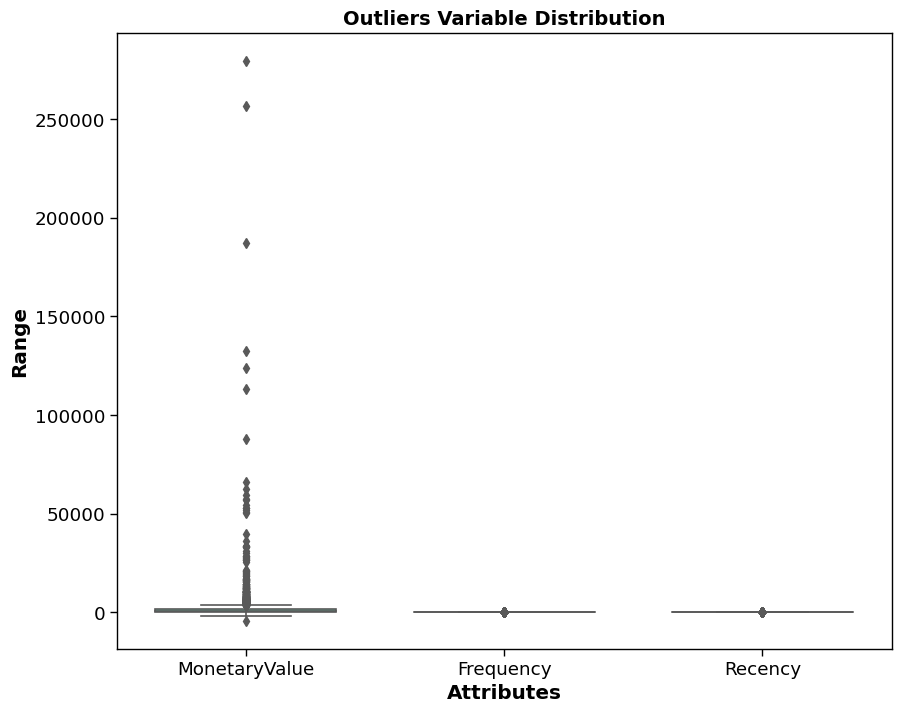

In [42]:
import plotly.graph_objects as go

# Select the attributes for outlier analysis
attributes = ['MonetaryValue', 'Frequency', 'Recency']

# Create a box plot using Seaborn
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=retail_rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')

# Convert the Seaborn plot to a Plotly figure
fig = go.Figure()
for attribute in attributes:
    fig.add_trace(go.Box(y=retail_rfm[attribute], name=attribute))

# Show the interactive Plotly figure
fig.show()


In [43]:
# Calculate and print the IQR for Amount
Q1 = retail_rfm.MonetaryValue.quantile(0.25)
Q3 = retail_rfm.MonetaryValue.quantile(0.75)
IQR = Q3 - Q1
print("IQR for Amount: ", IQR)

# Calculate and print the IQR for Recency
Q1 = retail_rfm.Recency.quantile(0.25)
Q3 = retail_rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
print("IQR for Recency: ", IQR)

# Calculate and print the IQR for Frequency
Q1 = retail_rfm.Frequency.quantile(0.25)
Q3 = retail_rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
print("IQR for Frequency: ", IQR)


IQR for Amount:  1316.54
IQR for Recency:  126.0
IQR for Frequency:  4.0


In [44]:
# Rescaling the attributes

retail_rfm_df = retail_rfm[['MonetaryValue', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
retail_rfm_scaled = scaler.fit_transform(retail_rfm_df)
retail_rfm_scaled.shape

(4372, 3)

In [45]:
retail_rfm_scaled = pd.DataFrame(retail_rfm_scaled)
retail_rfm_scaled.columns = ['MonetaryValue', 'Frequency', 'Recency']
retail_rfm_scaled.head()

,MonetaryValue,Frequency,Recency
0,0.064244,0.206102,-0.814332
1,0.096475,0.527381,-0.834182
2,-0.004803,0.420288,-0.834182
3,0.103041,0.099010,-0.873883
4,1.836996,1.812496,-0.873883


# K Means Clustering Algorithm

In [46]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(retail_rfm_scaled)


KMeans(max_iter=50, n_clusters=4)

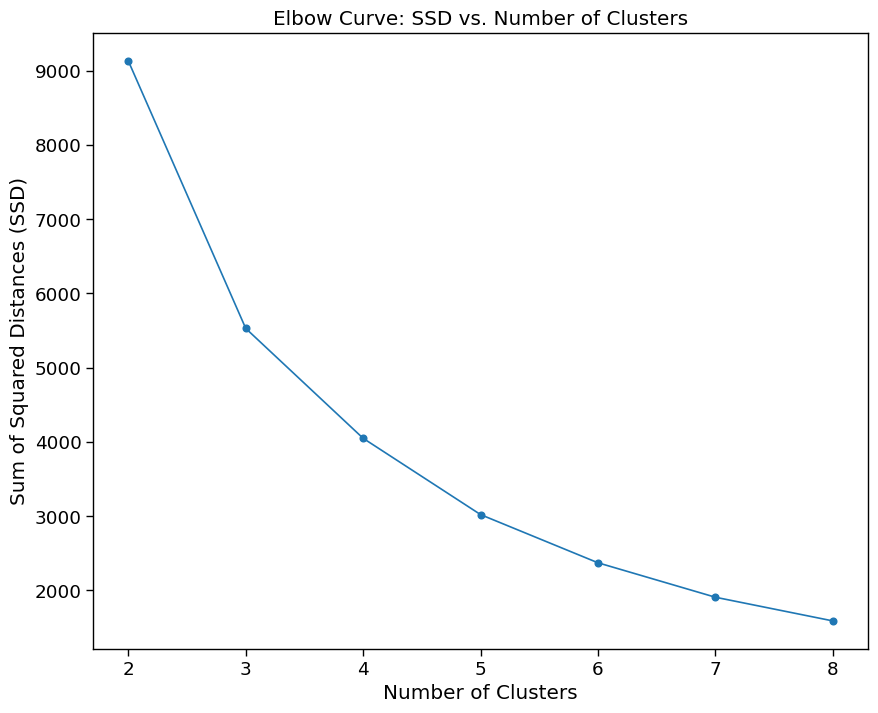

In [47]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Iterate over the range of cluster numbers
for num_clusters in range_n_clusters:
    # Create a KMeans object and fit the scaled RFM data
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10)  # Set n_init to 10 explicitly
    kmeans.fit(retail_rfm_scaled)

    # Append the SSD (inertia) to the ssd list
    ssd.append(kmeans.inertia_)

# Plot the SSDs for each n_clusters
plt.plot(range_n_clusters, ssd, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Curve: SSD vs. Number of Clusters')
plt.show()


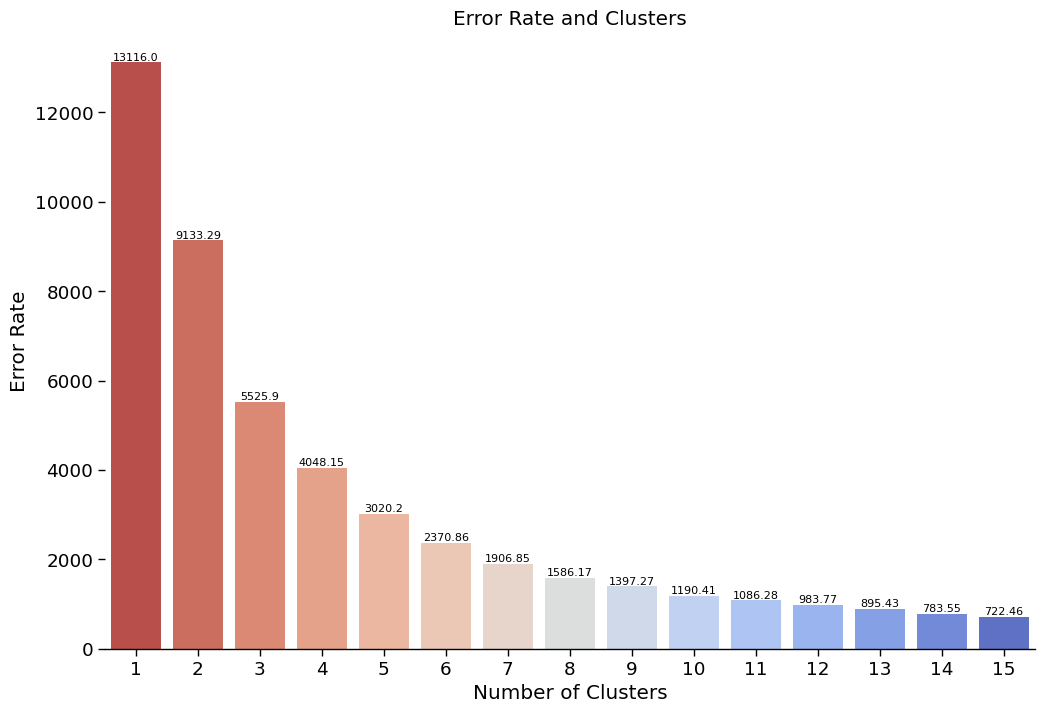

In [48]:
error_rate = []
clusters_range = range(1, 16)

# Iterate over the range of cluster numbers
for clusters in clusters_range:
    # Create a KMeans object and fit the scaled RFM data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        kmeans = KMeans(n_clusters=clusters, n_init=10)
        kmeans.fit(retail_rfm_scaled)
        kmeans.predict(retail_rfm_scaled)
        error_rate.append(kmeans.inertia_)

# Create a DataFrame to store the cluster numbers and corresponding error rates
error_rate_df = pd.DataFrame({'Cluster': clusters_range, 'Error': error_rate})

# Create a bar plot to visualize the error rate and clusters
plt.figure(figsize=(12, 8))
plot = sns.barplot(x='Cluster', y='Error', data=error_rate_df, palette='coolwarm_r')
sns.despine(left=True)
plot.set_title('Error Rate and Clusters')

# Add data labels to the bar plot with adjusted positioning
for i, row in error_rate_df.iterrows():
    plot.text(row.Cluster - 1, row.Error, f"{round(row.Error, 2)}", color='black', ha="center", va="bottom", fontsize=8)

# Add x-axis and y-axis labels
plt.xlabel('Number of Clusters')
plt.ylabel('Error Rate')

# Display the plot
plt.show()


In [49]:


# Suppress the warning related to n_init
warnings.filterwarnings('ignore', category=FutureWarning)

# Create a KMeans object with k=3 and fit the scaled RFM data
kmeans = KMeans(n_clusters=3, max_iter=50, n_init=10)
kmeans.fit(retail_rfm_scaled)


KMeans(max_iter=50, n_clusters=3, n_init=10)

In [50]:
# assign the label
retail_rfm['Cluster_Id'] = kmeans.labels_
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id
982,13658.0,2421.47,7,9,4,3,4,434,11,Gold,Potential Loyalists,0
1767,14732.0,2686.34,10,7,4,3,4,434,11,Gold,Potential Loyalists,0
3641,17293.0,1854.06,9,7,4,3,4,434,11,Gold,Potential Loyalists,0
1319,14121.0,2740.30,6,3,4,3,4,434,11,Gold,Potential Loyalists,0
1144,13881.0,16989.52,22,3,4,3,4,434,11,Gold,Potential Loyalists,0


In [51]:
retail_rfm.columns

Index(['CustomerID', 'MonetaryValue', 'Frequency', 'Recency', 'R', 'F', 'M',
       'RFM_Segment', 'RFM_Score', 'RFM_Level', 'Segment', 'Cluster_Id'],
      dtype='object')

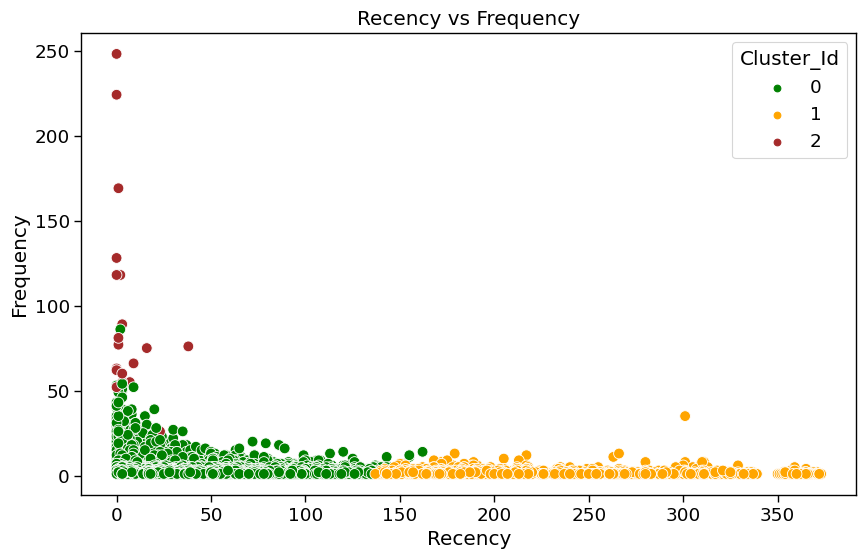

In [58]:
plt.figure(figsize=(10, 6))

# Create a scatter plot of Recency vs Frequency, colored by cluster ID
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster_Id',
                palette=['green', 'orange', 'brown'], legend='full', data=retail_rfm, s=60)

# Set x-axis and y-axis labels
plt.xlabel('Recency')
plt.ylabel('Frequency')

# Set plot title
plt.title('Recency vs Frequency')

# Display the plot
plt.show()


In [61]:
import plotly.graph_objects as go

# Create a trace for each cluster
traces = []
colors = ['blue', 'red', 'green']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

for i in range(3):
    trace = go.Scatter3d(
        x=retail_rfm['Frequency'][retail_rfm['Cluster_Id'] == i],
        y=retail_rfm['Recency'][retail_rfm['Cluster_Id'] == i],
        z=retail_rfm['MonetaryValue'][retail_rfm['Cluster_Id'] == i],
        mode='markers',
        marker=dict(
            color=colors[i],
            size=6,
            opacity=0.8
        ),
        name=cluster_labels[i],
        hovertext=retail_rfm['CustomerID'][retail_rfm['Cluster_Id'] == i],
        hovertemplate='<b>Customer ID:</b> %{hovertext}<br><b>Frequency:</b> %{x}<br><b>Recency:</b> %{y}<br><b>Monetary Value:</b> %{z}<extra></extra>'
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='3D Scatter Plot: Frequency vs Recency vs MonetaryValue',
    scene=dict(
        xaxis=dict(title='Frequency'),
        yaxis=dict(title='Recency'),
        zaxis=dict(title='MonetaryValue')
    ),
    hovermode='closest'
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


<Axes: xlabel='Cluster_Id', ylabel='MonetaryValue'>

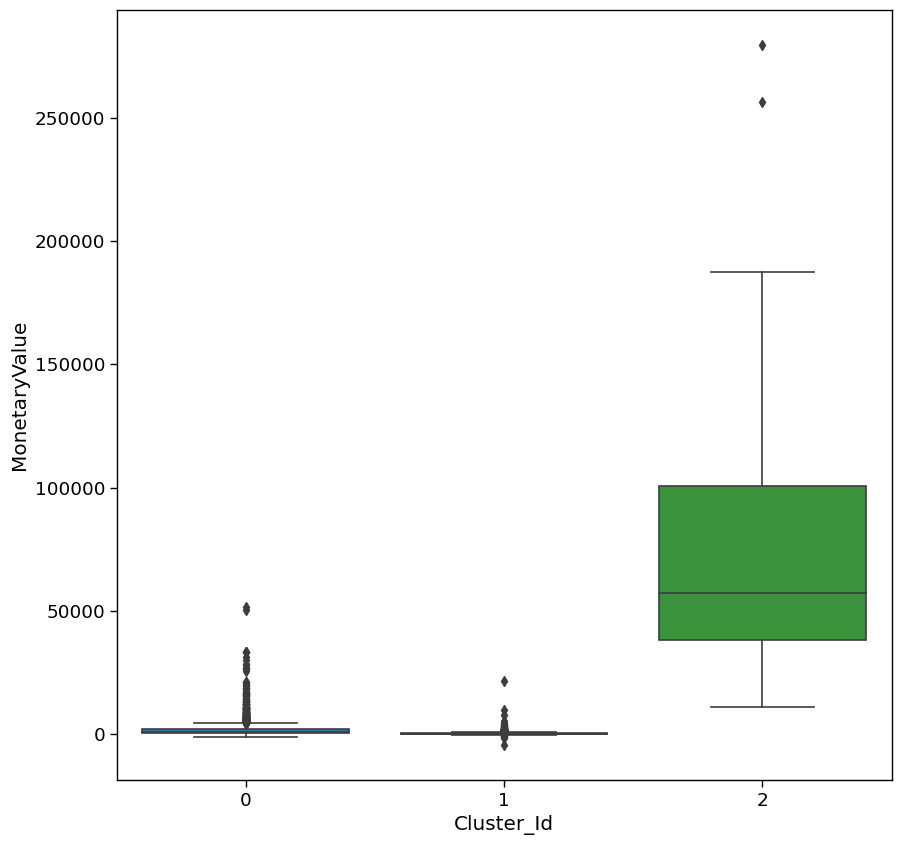

In [62]:
# Box plot to visualize Cluster Id vs Frequency
fig = plt.figure(figsize=(10,10))
sns.boxplot(x='Cluster_Id', y='MonetaryValue', data=retail_rfm)


<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

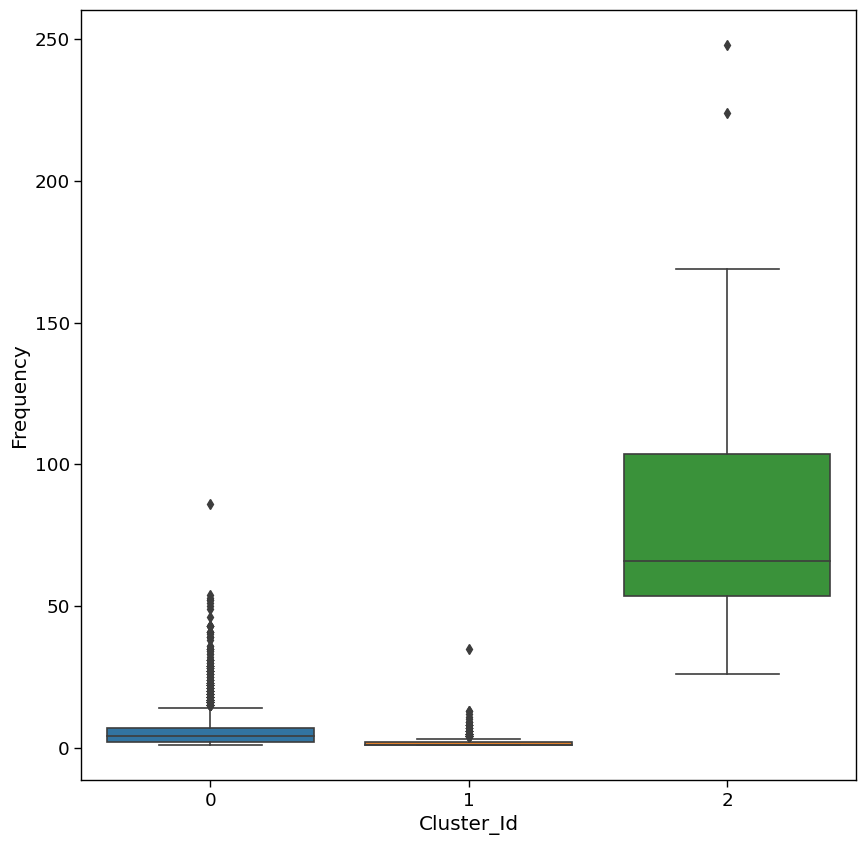

In [63]:
fig = plt.figure(figsize=(10,10))
sns.boxplot(x='Cluster_Id', y='Frequency', data=retail_rfm)


<Axes: xlabel='Cluster_Id', ylabel='Recency'>

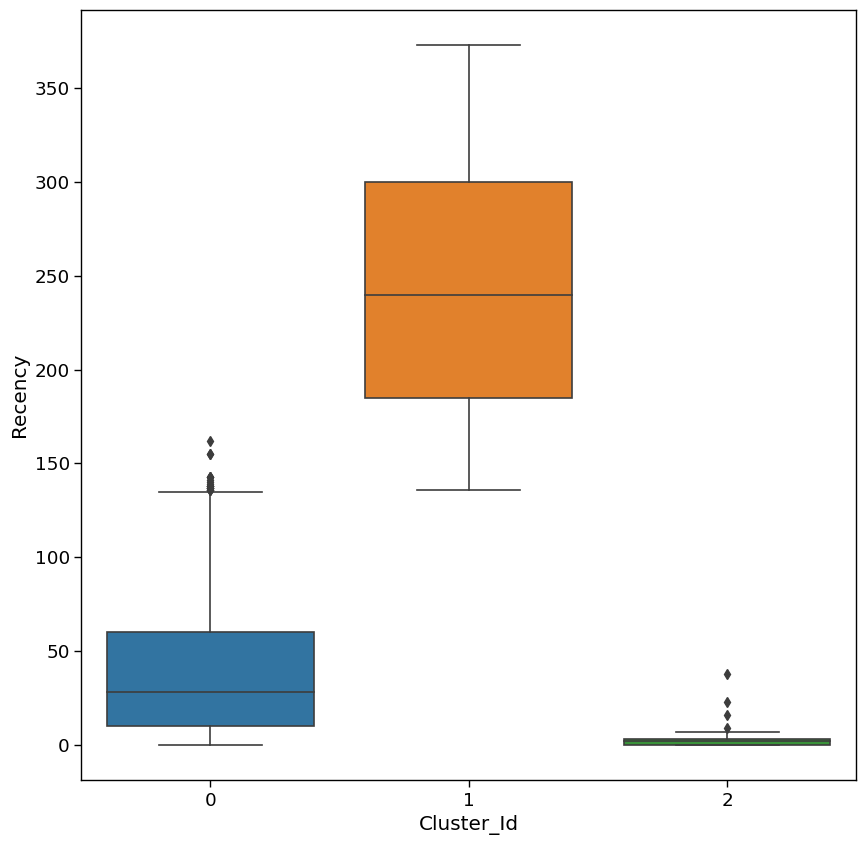

In [64]:
fig = plt.figure(figsize=(10,10))

sns.boxplot(x='Cluster_Id', y='Recency', data=retail_rfm)

# BIRCH Algorithm

In [65]:
retail_rfm.columns

Index(['CustomerID', 'MonetaryValue', 'Frequency', 'Recency', 'R', 'F', 'M',
       'RFM_Segment', 'RFM_Score', 'RFM_Level', 'Segment', 'Cluster_Id',
       'Frequency_scaled'],
      dtype='object')

In [66]:
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id,Frequency_scaled
982,13658.0,2421.47,7,9,4,3,4,434,11,Gold,Potential Loyalists,0,1.4
1767,14732.0,2686.34,10,7,4,3,4,434,11,Gold,Potential Loyalists,0,2.0
3641,17293.0,1854.06,9,7,4,3,4,434,11,Gold,Potential Loyalists,0,1.8
1319,14121.0,2740.30,6,3,4,3,4,434,11,Gold,Potential Loyalists,0,1.2
1144,13881.0,16989.52,22,3,4,3,4,434,11,Gold,Potential Loyalists,0,4.4


In [67]:
retail_rfm_new = retail_rfm[['CustomerID','MonetaryValue','Frequency','Recency']]
retail_rfm_new.head()

,CustomerID,MonetaryValue,Frequency,Recency
982,13658.0,2421.47,7,9
1767,14732.0,2686.34,10,7
3641,17293.0,1854.06,9,7
1319,14121.0,2740.30,6,3
1144,13881.0,16989.52,22,3


In [69]:
from sklearn.cluster import Birch

birch_cluster = Birch(n_clusters=3)
birch_cluster.fit(retail_rfm_scaled)  # Assuming retail_rfm_scaled is the normalized DataFrame
labels = birch_cluster.labels_

retail_rfm['birch_cluster'] = labels
retail_rfm.head()


,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id,Frequency_scaled,birch_cluster
982,13658.0,2421.47,7,9,4,3,4,434,11,Gold,Potential Loyalists,0,1.4,0
1767,14732.0,2686.34,10,7,4,3,4,434,11,Gold,Potential Loyalists,0,2.0,0
3641,17293.0,1854.06,9,7,4,3,4,434,11,Gold,Potential Loyalists,0,1.8,0
1319,14121.0,2740.30,6,3,4,3,4,434,11,Gold,Potential Loyalists,0,1.2,0
1144,13881.0,16989.52,22,3,4,3,4,434,11,Gold,Potential Loyalists,0,4.4,0


In [71]:
import plotly.graph_objects as go

# Create a trace for each cluster
traces = []
colors = ['blue', 'red', 'green']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

for i in range(3):
    trace = go.Scatter3d(
        x=retail_rfm['Frequency'][retail_rfm['Cluster_Id'] == i],
        y=retail_rfm['Recency'][retail_rfm['Cluster_Id'] == i],
        z=retail_rfm['MonetaryValue'][retail_rfm['Cluster_Id'] == i],
        mode='markers',
        marker=dict(
            color=colors[i],
            size=6,
            opacity=0.8
        ),
        name=cluster_labels[i],
        hovertext=retail_rfm['CustomerID'][retail_rfm['Cluster_Id'] == i],
        hovertemplate='<b>Customer ID:</b> %{hovertext}<br><b>Frequency:</b> %{x}<br><b>Recency:</b> %{y}<br><b>Monetary Value:</b> %{z}<extra></extra>'
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='3D Scatter Plot: Frequency vs Recency vs MonetaryValue',
    scene=dict(
        xaxis=dict(title='Frequency'),
        yaxis=dict(title='Recency'),
        zaxis=dict(title='MonetaryValue')
    ),
    hovermode='closest'
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


# DBSCAN Algorithm

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_principal = pca.fit_transform(retail_rfm_scaled)  # Assuming retail_rfm_scaled is the normalized DataFrame
X_principal = pd.DataFrame(X_principal, columns=['P1', 'P2'])
X_principal.head()


,P1,P2
0,0.489009,-0.685175
1,0.733295,-0.644371
2,0.596959,-0.699461
3,0.464152,-0.739491
4,2.717527,0.186433


In [74]:

from sklearn.cluster import DBSCAN
db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal)
labels = db_default.labels_

In [75]:
X_principal['P1'].head()

0    0.489009
1    0.733295
2    0.596959
3    0.464152
4    2.717527
Name: P1, dtype: float64

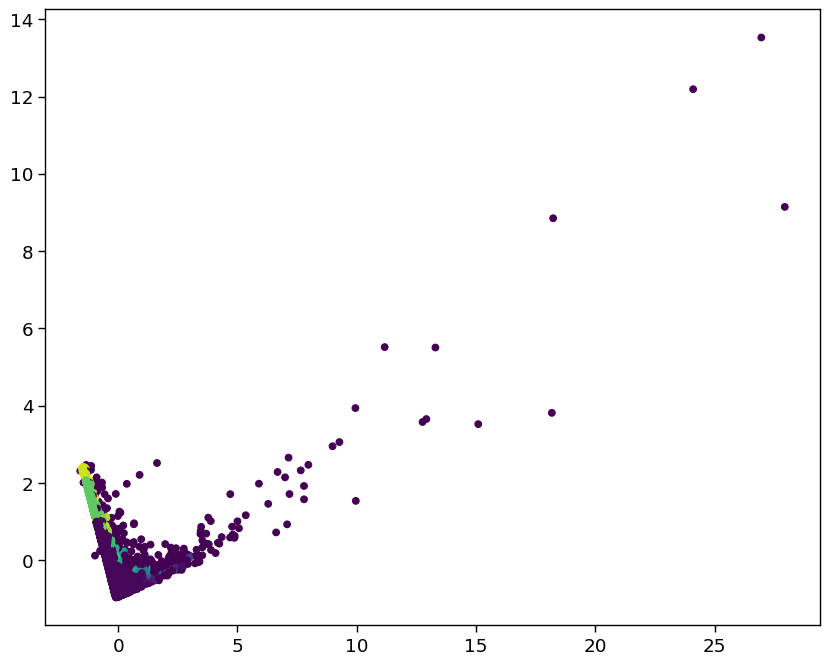

In [76]:
plt.scatter(X_principal['P1'],X_principal['P2'], c=labels)

Text(0, 0.5, 'Distance')

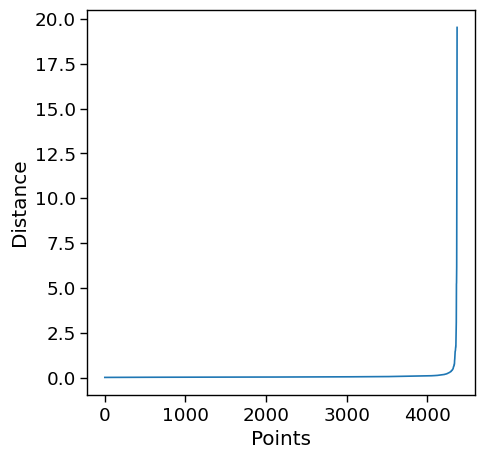

In [77]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_principal)

distances, indices = neighbors.kneighbors(X_principal)
distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

In [79]:
pip install kneed

0.08740765111359129


<Figure size 500x500 with 0 Axes>

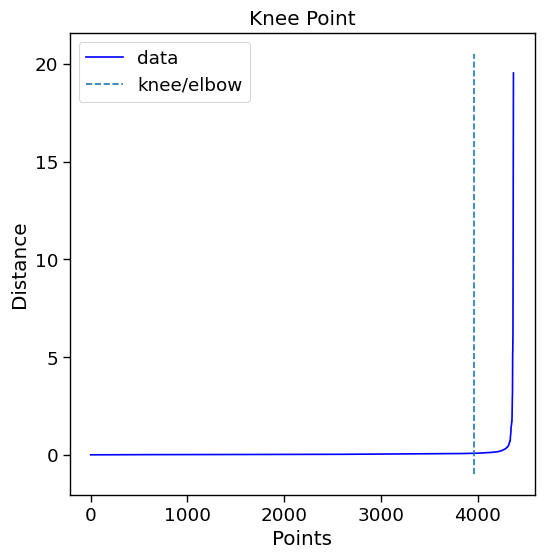

In [80]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

Estimated no. of clusters: 56
Estimated no. of noise points: 344


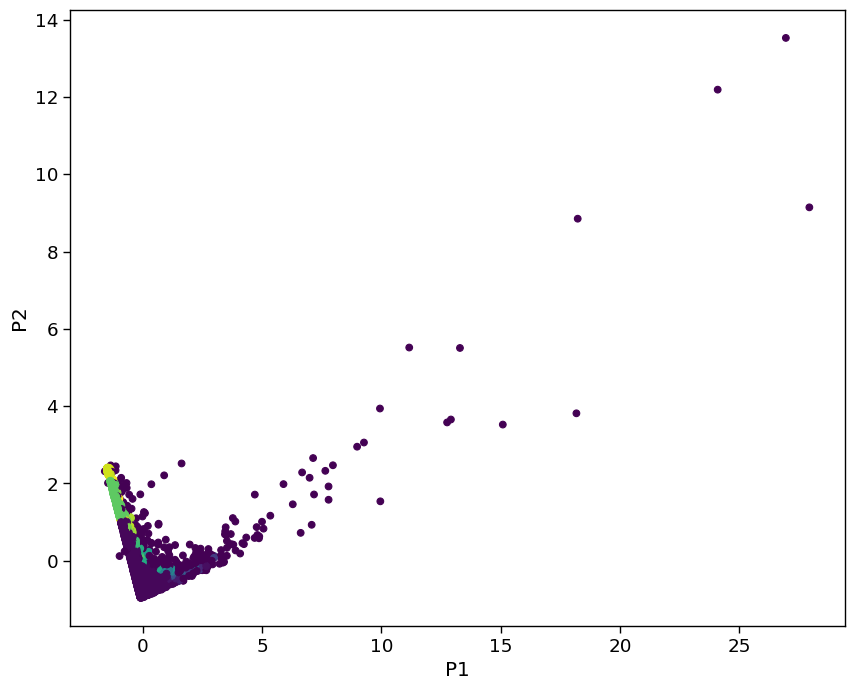

In [81]:
from sklearn.metrics import v_measure_score
dbscan_cluster = DBSCAN(eps=0.062, min_samples=8)
dbscan_cluster.fit(X_principal)

# Visualizing DBSCAN
plt.scatter(X_principal['P1'], X_principal['P2'], c=labels )
plt.xlabel("P1")
plt.ylabel("P2")

# Number of Clusters
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(db_default.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)



# Implementing Market Basket Analysis

In [82]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [83]:
data = df.copy()

In [84]:
#Data clean up which includes removing spaces from some of the descriptions
# Drop the rows that don’t have invoice numbers and remove the credit transactions
data['Description'] = data['Description'].str.strip()
data.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
data['InvoiceNo'] = data['InvoiceNo'].astype('str')
data = data[~data['InvoiceNo'].str.contains('C')]
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [85]:
data['Country'].value_counts()

United Kingdom          349227
Germany                   9027
France                    8327
EIRE                      7228
Spain                     2480
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1453
Australia                 1184
Norway                    1072
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

In [86]:
#After the clean-up, we need to consolidate the items into 1 transaction per row with each product
# For the sake of keeping the data set small, we are only looking at sales for France.
basket = (data[data['Country'] =="EIRE"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
581006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)

basket_sets

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
581006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
#Generate frequent itemsets that have a support value of at least 7%
# (this number is chosen so that you can get close enough)
# Generate the rules with their corresponding support, confidence and lift.
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.130769,0.107692,0.100000,0.764706,7.100840,0.085917,3.792308
1,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.107692,0.130769,0.100000,0.928571,7.100840,0.085917,12.169231
2,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.130769,0.242308,0.088462,0.676471,2.791783,0.056775,2.341958
3,(REGENCY CAKESTAND 3 TIER),(GREEN REGENCY TEACUP AND SAUCER),0.242308,0.130769,0.088462,0.365079,2.791783,0.056775,1.369038
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.169231,0.130769,0.119231,0.704545,5.387701,0.097101,2.942012


In [89]:
rules.shape

(60, 9)

In [90]:
rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.130769,0.107692,0.100000,0.764706,7.100840,0.085917,3.792308
1,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.107692,0.130769,0.100000,0.928571,7.100840,0.085917,12.169231
2,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.130769,0.242308,0.088462,0.676471,2.791783,0.056775,2.341958
3,(REGENCY CAKESTAND 3 TIER),(GREEN REGENCY TEACUP AND SAUCER),0.242308,0.130769,0.088462,0.365079,2.791783,0.056775,1.369038
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.169231,0.130769,0.119231,0.704545,5.387701,0.097101,2.942012
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.130769,0.169231,0.119231,0.911765,5.387701,0.097101,9.415385
6,(REGENCY CAKESTAND 3 TIER),(PINK REGENCY TEACUP AND SAUCER),0.242308,0.107692,0.076923,0.317460,2.947846,0.050828,1.307335
7,(PINK REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.107692,0.242308,0.076923,0.714286,2.947846,0.050828,2.651923
8,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.169231,0.107692,0.103846,0.613636,5.698052,0.085621,2.309502
9,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.107692,0.169231,0.103846,0.964286,5.698052,0.085621,23.261538
